In [44]:
library(limma) 
library(edgeR) 
library(ggplot2)
library(dplyr)
library('Glimma') 
library('wordspace')
library(RColorBrewer)
library(Rtsne)

>The code from this file is used to compute the results for the part 3.2 of the project: **RNA-Seq Data Analysis**.
The produre is the same as in the DEG file except that here we analyse only luminal A samples.

The datasets used in this file are :
1. df ( columns= lumA IDC or lumA ILC samples; rows= quantitative expression of a given gene).
2. gene_size (contains gene_id, gene name and gene lenght of each gene computed using "rentrez" package).
3. df_samples (contains sample_id andthe histlogical type associated to these samples).

# 3.2.1 Data processing

## Reading the data

In [17]:
df <- read.table("data/seq.csv",sep=",",header=TRUE)
df$X<-c()
head(df)
dim(df)

TCGA.A1.A0SD.01 TCGA.A1.A0SE.01 TCGA.A1.A0SF.01 TCGA.A1.A0SJ.01
1 11.3241           4.4426         10.7401          4.9419       
2 60.2630         153.1452        141.1933        134.8733       
3 83.6986          74.7018        314.4482         63.6488       
4  0.3308           0.0000          0.0000          0.3658       
5  0.0000           0.0000          0.0000          0.0000       
6  0.6616           0.0000          0.0000          0.0000       
  TCGA.A1.A0SM.01 TCGA.A1.A0SQ.01 TCGA.A2.A04V.01 TCGA.A2.A0CK.01
1   7.6484         1.0368           5.2638          2.6384       
2 119.4760        41.5532         166.4412        113.6646       
3  80.8081        75.8447         132.8173        263.0303       
4   0.3157         0.0000           0.0000          0.0000       
5   0.0000         0.0000           0.0000          0.0000       
6   0.0000         0.0000           0.0000          2.0202       
  TCGA.A2.A0CO.01 TCGA.A2.A0CP.01 ... TCGA.GM.A3NW.01 TCGA.GM.A3NY.01
1   6.4292          4.5107        ...   6.8182          7.4766       
2  97.5164         96.5147        ...  79.6378        116.2669       
3 281.5666        247.3190        ... 237.9897        453.7262       
4   2.0888          0.0000        ...   0.0000          0.6932       
5   0.0000          0.0000        ...   0.0000          0.0000       
6   0.4178          0.6702        ...   0.3695          0.3466       
  TCGA.GM.A3XG.01 TCGA.GM.A3XN.01 TCGA.GM.A4E0.01 TCGA.LL.A440.01
1   2.0821          6.7566          2.0267         13.1811       
2 144.9050        175.5820        148.0796        136.0213       
3 336.9480        601.4904        917.1449        708.0590       
4   0.0000          0.3549          2.2029          1.0001       
5   0.0000          0.0000          0.0000          0.0000       
6   1.0410          0.3549          0.0000          0.3334       
  TCGA.LL.A5YN.01 TCGA.LQ.A4E4.01 TCGA.MS.A51U.01 TCGA.OL.A66K.01
1   2.9624         14.1288          7.9343          4.3892       
2 100.3083        117.0300        150.6834        106.3475       
3 367.2936        307.2124        540.4278        554.5539       
4   0.5225          0.9974          1.5649          1.2434       
5   0.0000          0.0000          0.0000          0.0000       
6   2.0899          0.0000          0.5216          0.0000

[1] 20440   306

In [18]:
#upload the data with gene size
gene_size <- read.table("data/data_gene_name2.txt",header=TRUE,sep=',')
gene_size$X<-c()

dim(gene_size)

[1] 20440     3

In [19]:
#create a list of gene availables in the gene_size document
gene_list<- gene_size$gene_id

rownames(df)<-gene_list
head(df)

TCGA.A1.A0SD.01 TCGA.A1.A0SE.01 TCGA.A1.A0SF.01 TCGA.A1.A0SJ.01
100134869 11.3241           4.4426         10.7401          4.9419       
10357     60.2630         153.1452        141.1933        134.8733       
155060    83.6986          74.7018        314.4482         63.6488       
26823      0.3308           0.0000          0.0000          0.3658       
280660     0.0000           0.0000          0.0000          0.0000       
340602     0.6616           0.0000          0.0000          0.0000       
          TCGA.A1.A0SM.01 TCGA.A1.A0SQ.01 TCGA.A2.A04V.01 TCGA.A2.A0CK.01
100134869   7.6484         1.0368           5.2638          2.6384       
10357     119.4760        41.5532         166.4412        113.6646       
155060     80.8081        75.8447         132.8173        263.0303       
26823       0.3157         0.0000           0.0000          0.0000       
280660      0.0000         0.0000           0.0000          0.0000       
340602      0.0000         0.0000           0.0000          2.0202       
          TCGA.A2.A0CO.01 TCGA.A2.A0CP.01 ... TCGA.GM.A3NW.01 TCGA.GM.A3NY.01
100134869   6.4292          4.5107        ...   6.8182          7.4766       
10357      97.5164         96.5147        ...  79.6378        116.2669       
155060    281.5666        247.3190        ... 237.9897        453.7262       
26823       2.0888          0.0000        ...   0.0000          0.6932       
280660      0.0000          0.0000        ...   0.0000          0.0000       
340602      0.4178          0.6702        ...   0.3695          0.3466       
          TCGA.GM.A3XG.01 TCGA.GM.A3XN.01 TCGA.GM.A4E0.01 TCGA.LL.A440.01
100134869   2.0821          6.7566          2.0267         13.1811       
10357     144.9050        175.5820        148.0796        136.0213       
155060    336.9480        601.4904        917.1449        708.0590       
26823       0.0000          0.3549          2.2029          1.0001       
280660      0.0000          0.0000          0.0000          0.0000       
340602      1.0410          0.3549          0.0000          0.3334       
          TCGA.LL.A5YN.01 TCGA.LQ.A4E4.01 TCGA.MS.A51U.01 TCGA.OL.A66K.01
100134869   2.9624         14.1288          7.9343          4.3892       
10357     100.3083        117.0300        150.6834        106.3475       
155060    367.2936        307.2124        540.4278        554.5539       
26823       0.5225          0.9974          1.5649          1.2434       
280660      0.0000          0.0000          0.0000          0.0000       
340602      2.0899          0.0000          0.5216          0.0000

In [20]:
#dataframe containing the type of cancer for each patient (IDC or ILC)
df_samples <- read.table("data/seq_samples.csv",sep=',',header=TRUE)

#df_samples$group<- as.factor(df_samples$group)
df_samples$X<-c()
df_samples <-df_samples[order(df_samples$SAMPLE_ID),]

head(df_samples)

SAMPLE_ID       group
52  TCGA-A1-A0SD-01 IDC  
55  TCGA-A1-A0SE-01 ILC  
54  TCGA-A1-A0SF-01 IDC  
51  TCGA-A1-A0SJ-01 IDC  
240 TCGA-A1-A0SM-01 IDC  
239 TCGA-A1-A0SQ-01 IDC

In [21]:
#create a DGE list with all the necessary information
x<-DGEList(df,genes=gene_size,samples=df_samples)
x

An object of class "DGEList"
$counts
          TCGA.A1.A0SD.01 TCGA.A1.A0SE.01 TCGA.A1.A0SF.01 TCGA.A1.A0SJ.01
100134869         11.3241          4.4426         10.7401          4.9419
10357             60.2630        153.1452        141.1933        134.8733
155060            83.6986         74.7018        314.4482         63.6488
26823              0.3308          0.0000          0.0000          0.3658
280660             0.0000          0.0000          0.0000          0.0000
          TCGA.A1.A0SM.01 TCGA.A1.A0SQ.01 TCGA.A2.A04V.01 TCGA.A2.A0CK.01
100134869          7.6484          1.0368          5.2638          2.6384
10357            119.4760         41.5532        166.4412        113.6646
155060            80.8081         75.8447        132.8173        263.0303
26823              0.3157          0.0000          0.0000          0.0000
280660             0.0000          0.0000          0.0000          0.0000
          TCGA.A2.A0CO.01 TCGA.A2.A0CP.01 TCGA.A2.A0CQ.01 TCGA.A2.A0CR.01
100134869          6.4292          4.5107          5.7526          4.9047
10357             97.5164         96.5147         86.5958        115.1087
155060           281.5666        247.3190        400.5360        201.0924
26823              2.0888          0.0000          1.7865          0.0000
280660             0.0000          0.0000          0.0000          0.0000
          TCGA.A2.A0CS.01 TCGA.A2.A0CU.01 TCGA.A2.A0CV.01 TCGA.A2.A0D3.01
100134869          2.6627          5.2157          5.8939          4.4688
10357             77.7942         73.5739         63.6091         88.3701
155060            27.2266        176.4032        102.2903        194.0996
26823              0.4615          0.3818          0.0000          0.9673
280660             0.0000          0.0000          0.0000          0.0000
          TCGA.A2.A0EN.01 TCGA.A2.A0EO.01 TCGA.A2.A0EP.01 TCGA.A2.A0ET.01
100134869          5.2178          2.9878          6.1063          6.4382
10357             92.5505        107.2489        141.1230        122.1587
155060           169.0843         75.3228        404.9837        254.6046
26823              0.0000          0.3587          0.3322          0.8126
280660             0.0000          0.0000          0.0000          0.0000
          TCGA.A2.A0EU.01 TCGA.A2.A0EV.01 TCGA.A2.A0EX.01 TCGA.A2.A0SU.01
100134869          8.5387          3.5263          4.6016          4.3952
10357             95.1809        134.5123        153.9054        417.4946
155060           128.3382        142.8070        102.8897         66.7241
26823              0.0000          1.0526          0.0000          0.0000
280660             0.0000          0.0000          0.0000          0.0000
          TCGA.A2.A0SY.01 TCGA.A2.A0T4.01 TCGA.A2.A0T5.01 TCGA.A2.A0T6.01
100134869          2.9895          1.4104          3.3263          2.0738
10357            143.6829        152.0595        120.5106        112.2249
155060           115.3310         61.9815        138.5976        284.1596
26823              1.0453          0.0000          0.0000          0.3023
280660             0.0000          0.0000          0.0000          0.0000
          TCGA.A2.A0T7.01 TCGA.A2.A0YC.01 TCGA.A2.A0YD.01 TCGA.A2.A0YF.01
100134869          4.6075          2.1156          5.1276          3.7434
10357            121.6350         79.4163         57.2574        106.4267
155060           119.3038        242.8815        157.1785         48.3528
26823              0.2889          1.1390          0.3221          0.0000
280660             0.0000          0.0000          0.0000          0.0000
          TCGA.A2.A0YL.01 TCGA.A2.A1FV.01 TCGA.A2.A1FZ.01 TCGA.A2.A1G0.01
100134869          2.2616         11.9273          3.8519          3.0901
10357            113.0488         69.7710        104.4808         85.4372
155060           172.0189        704.5576        139.0153        270.8744
26823              1.2813          1.8261          0.0000          0.3287
280660             0.0000          0.0000

## Row scale transformation to CPM

In [22]:
lcpm<-cpm(x,log=TRUE)

## Gene filtering


In [23]:
L <- mean(x$samples$lib.size) * 1e-6
M <- median(x$samples$lib.size) * 1e-6
c(L, M)

[1] 18.91900 18.80971

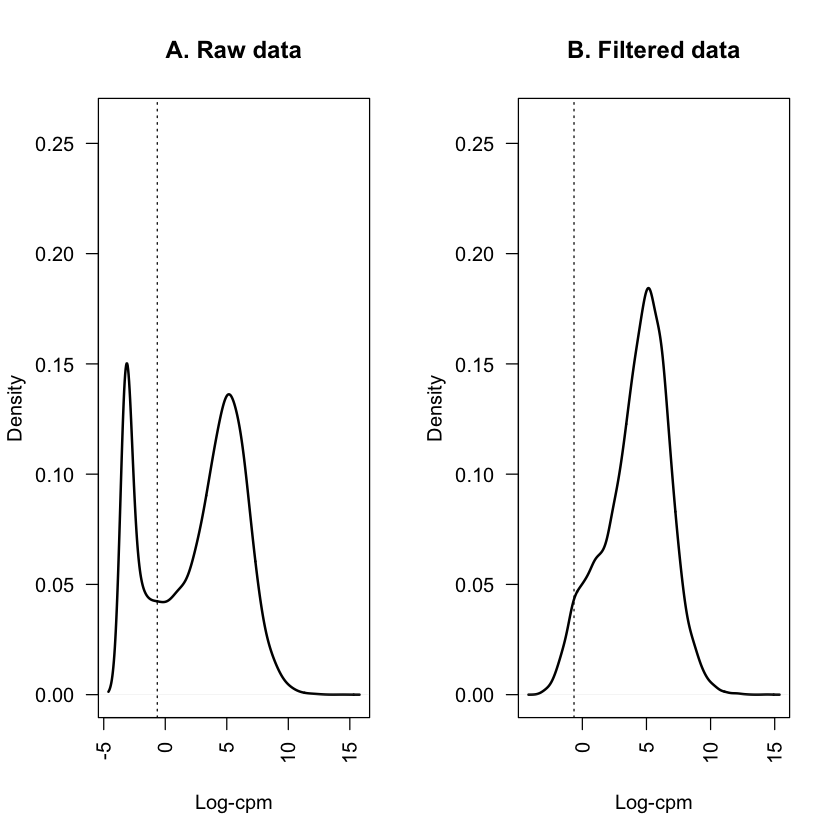

In [24]:
#png(file="fig/filtered.png",width=3500,height=2000,res=500)

par(mfrow=c(1,1))

lcpm.cutoff <- log2(10/M + 2/L)
par(mfrow=c(1,2))

plot(density(lcpm[,1]), col='black', lwd=2, ylim=c(0,0.26), las=2, main="", xlab="")
title(main="A. Raw data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)

keep.exprs <- filterByExpr(x, group=x$samples$group)
x <- x[keep.exprs,, keep.lib.sizes=FALSE]
lcpm <- cpm(x, log=TRUE)
plot(density(lcpm[,1]), col='black', lwd=2, ylim=c(0,0.26), las=2, main="", xlab="")
title(main="B. Filtered data", xlab="Log-cpm")
abline(v=lcpm.cutoff, lty=3)

#dev.off()

In [27]:

dim(x)
print("1540 genes were kept after the filtering procedure.")

[1] 15470   306

[1] "1540 genes were kept after the filtering procedure."


## Normalization: TMM Methods

In [28]:
x <- calcNormFactors(x, method = "TMM")

In [29]:
lcmp<-cpm(x,log=TRUE)
subset_after<-as.data.frame( lcpm[,1:10])

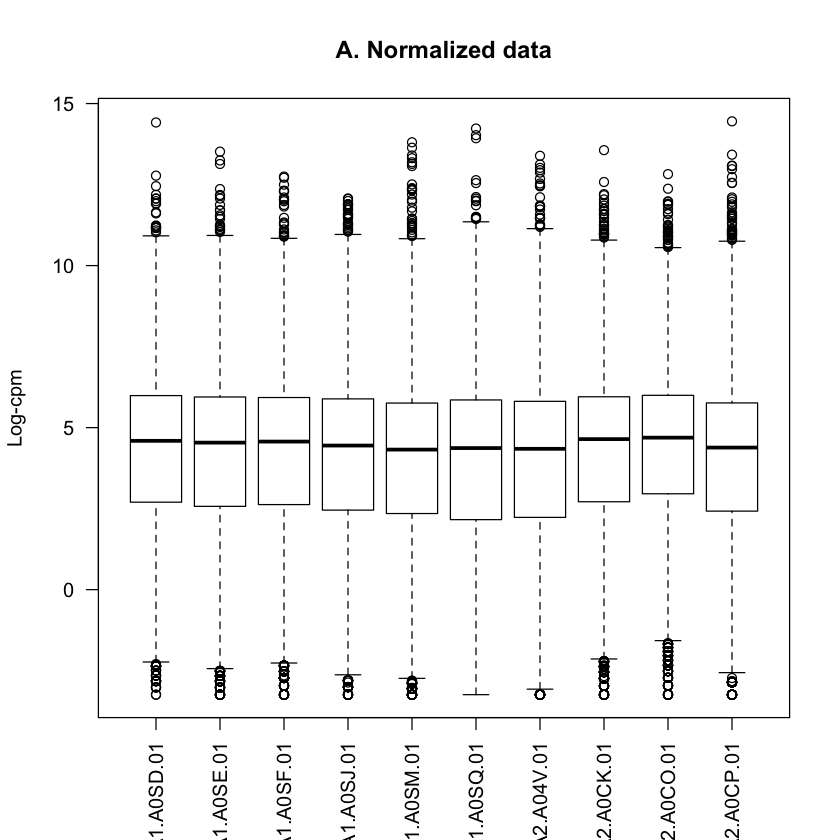

In [30]:


boxplot(subset_after, las=2, main="",col="white")
title(main="A. Normalized data", ylab="Log-cpm")


# 3.2.2 Exploratory Data Analysis


## Principal Component Analysis

In [31]:
lcpm.pca <- prcomp(t(lcpm), center = TRUE) 

In [32]:
plot(lcpm.pca$x[,1], lcpm.pca$x[,2],main="PCA-Biplot",xlab="PC1",ylab="PC2")


In [33]:
cluster_name<-x$samples

In [34]:
cluster_name$lib.size<-NULL
cluster_name$norm.factors<-NULL
cluster_name$sample_id<-NULL

In [38]:
lcpm.pca$group<-cluster_name

In [40]:
data_plot <- data.frame(lcpm.pca$x[,1], lcpm.pca$x[,2])
colnames(data_plot)=c('PCA1', 'PCA2')

In [41]:
data_plot$group<-cluster_name$group

In [42]:
head(cluster_name)

group SAMPLE_ID      
TCGA.A1.A0SD.01 IDC   TCGA-A1-A0SD-01
TCGA.A1.A0SE.01 ILC   TCGA-A1-A0SE-01
TCGA.A1.A0SF.01 IDC   TCGA-A1-A0SF-01
TCGA.A1.A0SJ.01 IDC   TCGA-A1-A0SJ-01
TCGA.A1.A0SM.01 IDC   TCGA-A1-A0SM-01
TCGA.A1.A0SQ.01 IDC   TCGA-A1-A0SQ-01

In [88]:
#png(file="fig/PCA_lumA.png",width=1500,height=1000,res=200)
ggplot(data_plot, aes(x=PCA1, y=PCA2, color=group)) + geom_point()+
  ggtitle("") +xlab("PC1")+ ylab("PC2")+
  theme( 
    plot.title = element_text(color="black", size=12, face="bold",hjust =1/2),
    axis.title.x = element_text(color="black", size=10),
    axis.title.y = element_text(color="black", size=10))+theme_bw() + theme(legend.position='top', legend.box = "horizontal",legend.title = element_text(size=14), 
           legend.text = element_text(size=14)) + 
  scale_color_manual(name="Histological subtype", labels = c("IDC","ILC"), values = c("IDC"="#3A8EBA", "ILC"="#BB0B0B"))
#dev.off()

# 3.2.3 Differential Gene Expression Analysis


In [49]:
#design matrix
design <- model.matrix(~0+x$samples$group)
colnames(design) <- c('IDC','ILC')
head(design)

IDC ILC
1 1   0  
2 0   1  
3 1   0  
4 1   0  
5 1   0  
6 1   0

In [50]:
#contraste matrix
contr.matrix <- makeContrasts(
   ILCvsIDC = ILC-IDC,
   levels = colnames(design))
contr.matrix

Contrasts
Levels ILCvsIDC
   IDC -1      
   ILC  1

In [51]:
#Means (x-axis) and variances (y-axis)
v <- voom(x, design, plot=TRUE)


In [52]:
plot<-v$plot

In [53]:
#png(file="fig/before_var.png",width=3500,height=2000,res=500)
plot
#dev.off()

NULL

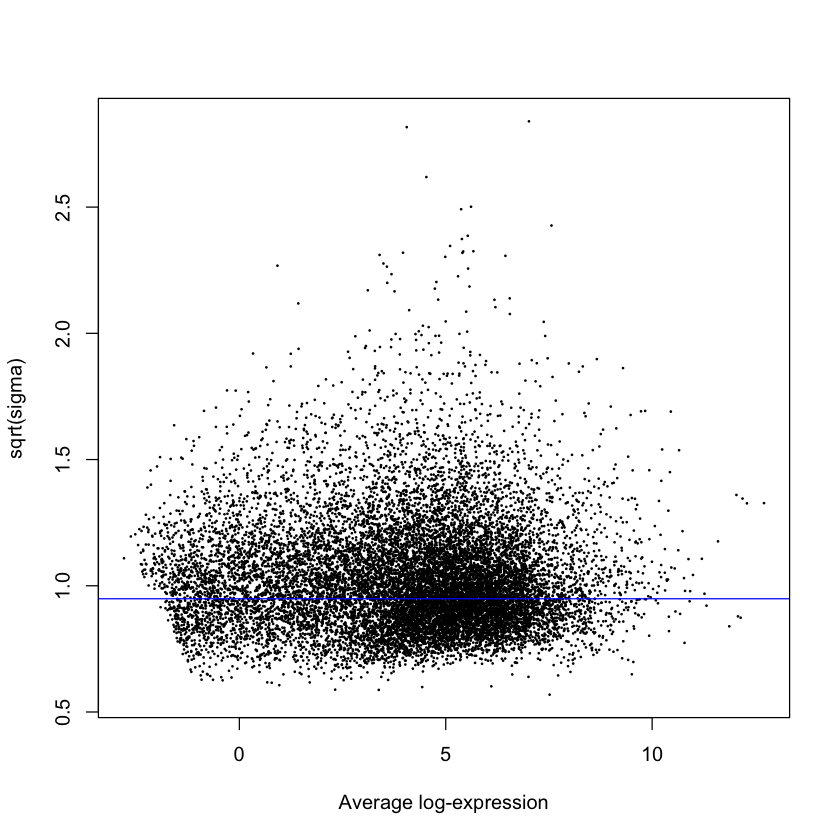

In [54]:
#fit a separate linear model to the expression values for each gene
vfit <- lmFit(v, design)
vfit <- contrasts.fit(vfit, contrasts=contr.matrix)

#precise estimates of gene-wise variability
efit <- eBayes(vfit)
#png(file="fig/efit.png",width=3000,height=2000,res=500)
#mean is independant of the variance
plotSA(efit)
#dev.off()

In [55]:
#number of significantly up- and down-regulated
summary(decideTests(efit))

       ILCvsIDC
Down       3732
NotSig     7654
Up         4084

In [56]:
#stricter definition on significance: require log-fold-changes (log-FCs) to be above a minimum value
tfit <- treat(vfit, lfc=1)
dt <- decideTests(tfit)
summary(dt)

       ILCvsIDC
Down          2
NotSig    15442
Up           26

### Significant Differential Gene Expression 

In [57]:
ILC.vs.IDC <- topTreat(tfit,p.value=0.05,sort.by ='AveExpr',  n=Inf)

In [58]:
#logFC gives the direction
ILC.vs.IDC

gene_id gene_name length logFC     AveExpr     t          P.Value     
999       999  CDH1       98245 -2.784683  8.30839013 -12.139563 2.776768e-28
1301     1301  COL11A1   232113 -2.169581  6.55312631  -4.157343 2.088504e-05
7021     7021  TFAP2B     29927  2.550098  4.77303345   4.634047 2.649665e-06
125       125  ADH1B      16430  2.405018  4.11411995   4.335543 9.857270e-06
2532     2532  ACKR1       1625  2.166893  3.99543665   5.124984 2.630583e-07
730       730  C7         75146  2.278429  3.73278928   5.328447 9.579342e-08
6358     6358  CCL14       3441  1.711522  3.63254298   4.237784 1.492793e-05
91851   91851  CHRDL1    121961  2.005929  3.14629562   4.167650 2.001132e-05
134548 134548  SOWAHA      3484  2.269896  2.45282141   4.905569 7.554251e-07
22915   22915  MMRN1      75118  1.684028  2.36145686   4.068671 3.006014e-05
4222     4222  MEOX1      21588  1.895838  1.82599028   4.492284 4.988053e-06
221476 221476  PI16       16574  2.108154  1.56602678   3.809803 8.393639e-05
286753 286753  TUSC5      21316  2.365921  1.51826003   4.147166 2.178351e-05
63924   63924  CIDEC      13544  2.254264  1.39700808   3.862404 6.842959e-05
92293   92293  TMEM132C  440745  2.076947  0.41588265   4.709892 1.876826e-06
5348     5348  FXYD1       5903  1.965020  0.31416658   4.988260 5.097701e-07
11012   11012  KLK11       5760  2.639615  0.05309306   4.080545 2.863999e-05
345557 345557  PLCXD3    203649  1.930598 -0.02516651   5.197927 1.837773e-07
10840   10840  ALDH1L1    94197  1.905367 -0.08327990   4.093874 2.712173e-05
1674     1674  DES         8357  2.097768 -0.17108019   4.086564 2.794467e-05
1149     1149  CIDEA      23234  2.349745 -0.22766122   4.446525 6.097634e-06
554       554  AVPR2       4541  1.697611 -0.33727280   4.706013 1.910433e-06
79785   79785  RERGL       9324  2.211654 -0.47221966   5.859664 5.953024e-09
7044     7044  LEFTY2      4894  1.977188 -1.28407979   5.074228 3.368388e-07
7140     7140  TNNT3      19153  2.213540 -1.35209389   5.471597 4.621663e-08
64344   64344  HIF3A      46391  1.899042 -1.56722669   4.632744 2.665310e-06
414332 414332  LCN10       4770  1.708494 -1.76530010   3.866820 6.725928e-05
91156   91156  IGFN1      38172  1.949708 -2.30034638   4.591863 3.203707e-06
       adj.P.Val   
999    4.295660e-24
1301   1.604718e-02
7021   3.171719e-03
125    8.970116e-03
2532   6.782519e-04
730    3.704811e-04
6358   1.282972e-02
91851  1.604718e-02
134548 1.298492e-03
22915  1.860121e-02
4222   5.144345e-03
221476 4.637485e-02
286753 1.604718e-02
63924  3.920762e-02
92293  2.686763e-03
5348   9.857679e-04
11012  1.846086e-02
345557 5.686071e-04
10840  1.846086e-02
1674   1.846086e-02
1149   5.895650e-03
554    2.686763e-03
79785  4.604664e-05
7044   7.444137e-04
7140   2.383238e-04
64344  3.171719e-03
414332 3.920762e-02
91156  3.540097e-03

### Up-regulated genes


In [59]:
#p-value of pten above 0.05
up_regulated=ILC.vs.IDC[ILC.vs.IDC$logFC>0, ]
#234
dim(up_regulated)
(up_regulated$gene_name)

[1] 26  8

[1] TFAP2B   ADH1B    ACKR1    C7       CCL14    CHRDL1   SOWAHA   MMRN1   
 [9] MEOX1    PI16     TUSC5    CIDEC    TMEM132C FXYD1    KLK11    PLCXD3  
[17] ALDH1L1  DES      CIDEA    AVPR2    RERGL    LEFTY2   TNNT3    HIF3A   
[25] LCN10    IGFN1   
20440 Levels: A1BG A1BG-AS1 A1CF A2M A2M-AS1 A2ML1 A4GALT A4GNT AAAS ... ZZZ3

### Down-regulated genes

In [60]:
#p-value of pten above 0.05
down_regulated=ILC.vs.IDC[ILC.vs.IDC$logFC<0, ]
#28
dim(down_regulated)
down_regulated$gene_name

[1] 2 8

[1] CDH1    COL11A1
20440 Levels: A1BG A1BG-AS1 A1CF A2M A2M-AS1 A2ML1 A4GALT A4GNT AAAS ... ZZZ3

### Mean-Difference plot

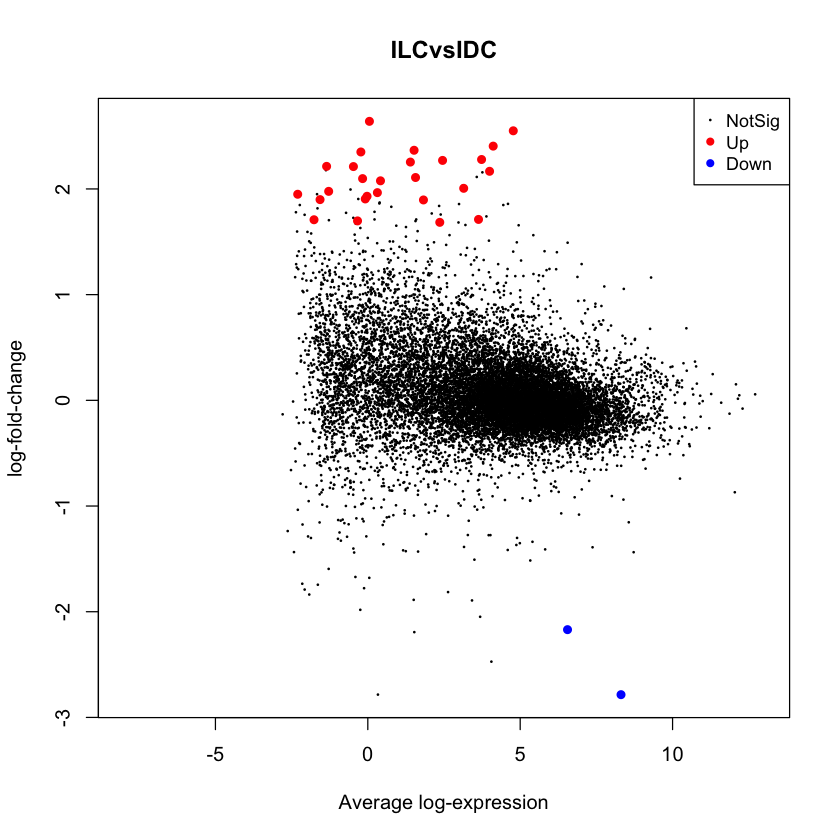

In [61]:
#png(file="fig/DEG_A.png",width=2000,height=1300,res=300)
plotMD(tfit,  status=dt[,1], main=colnames(tfit)[1], xlim=c(-8,13))
#dev.off()

### Heatmap

In [64]:
colnames(lcpm)<-NULL
colnames(lcpm)<-v$targets$group
head(lcpm)
#lcpm<-lcpm[ ,order(colnames(lcpm))]


IDC          ILC      IDC      IDC       IDC       IDC        IDC       
10357   1.746761840 3.042230 2.924237  2.804965 2.5048306 1.14188541  3.0507183
155060  2.207899911 2.025874 4.068264  1.745805 1.9534946 1.97835244  2.7298052
653553  3.625963235 4.002209 3.883039  5.025348 3.1161213 2.63331039  4.6308401
8225    3.881356534 4.666218 5.304917  4.326287 4.5385008 4.51014830  4.6924697
90288  -0.002962985 2.442372 3.387055 -1.520844 0.4243433 0.06221567 -0.6747523
1       2.959864213 3.370761 4.120077  3.545774 3.8521266 5.53864460  2.8774535
       ILC      ILC      IDC      ... ILC       ILC      ILC      ILC     
10357  2.646451 2.454257 2.231036 ... 2.1696186 2.599094 2.956288 3.220834
155060 3.842985 3.965692 3.568624 ... 3.7262373 4.544614 4.162453 4.985590
653553 4.703553 4.341620 5.124042 ... 4.7933320 5.107850 4.210388 4.855168
8225   5.566502 5.473367 5.015942 ... 5.8881560 5.121890 5.808840 4.902663
90288  1.278077 2.681314 2.231036 ... 0.3880256 3.260522 1.671625 2.622986
1      4.014845 4.078636 4.153638 ... 5.1520809 5.116984 3.732316 4.100093
       ILC         ILC      IDC      ILC      ILC      ILC     
10357   3.02832566 2.764930 2.277906 2.798977 3.020830 2.619957
155060  5.64332646 5.126708 4.127335 4.177692 4.849783 4.982287
653553  4.51269896 3.594212 4.992425 3.213616 3.544716 5.935603
8225    5.47479106 5.284357 6.053661 4.790615 5.053861 5.647205
90288  -0.08253017 1.244213 3.185861 2.229980 1.791327 3.269286
1       2.87687952 3.489750 4.426366 4.873634 4.276604 4.590466

In [65]:
library(gplots)
ILC.vs.IDC.topgenes <- ILC.vs.IDC$gene_name[1:50]
i <- which(v$genes$gene_name %in% ILC.vs.IDC.topgenes)
mycol <- colorpanel(1000,"blue","white","red")

In [66]:
head(lcpm[i,])

IDC       ILC        IDC      IDC      IDC        IDC        IDC       
125    5.9773126 2.48802192 5.993623 7.619332 -0.9493581  4.9082385  5.4214655
10840  1.2460059 0.77687024 2.012468 2.603872 -3.2404044 -1.8943923  0.2229151
134548 2.1158784 4.95905010 5.168546 0.439873  1.0550299 -0.6070672  1.4900882
554    0.3193284 0.04534498 1.041881 0.993603 -1.9013719 -0.4380793 -0.6293600
730    5.3200740 4.09068400 6.707751 6.736560  1.3413911  4.6014657  2.7684755
6358   4.0692402 4.81333282 5.877472 5.556763  2.3405948  3.2052070  3.1821192
       ILC      ILC      IDC        ... ILC      ILC        ILC      ILC     
125    7.473739 8.046194  5.5686616 ... 5.351103  4.6318853 3.192811 7.416035
10840  2.718628 3.187167 -0.1998677 ... 1.661636 -0.5321945 2.171750 2.841208
134548 2.550999 5.028514  2.2601208 ... 4.406371  5.8911512 2.788122 6.252171
554    2.039123 3.233814  1.0796046 ... 1.977618  0.3529682 1.261482 1.599588
730    6.116441 7.129518  5.7453172 ... 3.998799  3.2922337 2.776589 4.978787
6358   5.901972 7.078069  4.4530410 ... 4.135602  4.7267937 5.543323 4.830811
       ILC      ILC        IDC        ILC      ILC       ILC          
125    9.043016 7.29895068  1.8036289 6.967398 6.3730291  2.8465877156
10840  4.814474 2.78556211 -0.5169760 2.068588 1.0138458 -0.8541952048
134548 5.427384 0.07992231  2.7501520 5.712714 6.9197064  5.1350970381
554    4.169574 2.17542202  0.2546161 1.270916 0.3454371  0.0007785974
730    6.210642 6.99762521  4.1970165 4.543816 5.2090145  4.8365388691
6358   7.572768 6.17874928  3.9972132 4.076430 3.2447458  4.4125545020

In [67]:
mydist=function(x) {as.dist(1-cor(t(x)))}
myclust=function(x) {hclust(x, method="ward.D")}
#group_df[group_df$group=="IDC","color"] = "cyan"
#group_df[group_df$group=="ILC","color"] = "orange"

In [68]:
mycol <- colorpanel(200,"blue","white","#FF0000")


#FF0000
#33FFFF
library("gplots")

In [69]:
prob_matrix=data.matrix(lcmp[i,])

In [70]:
group_df = data.frame(v$targets) 
group_df[group_df$group=="IDC","color"] = "#1565C0"
group_df[group_df$group=="ILC","color"] = "#FF9900"

In [71]:
head(group_df)

group lib.size norm.factors SAMPLE_ID       color  
TCGA.A1.A0SD.01 IDC   19438559 1.0484015    TCGA-A1-A0SD-01 #1565C0
TCGA.A1.A0SE.01 ILC   19362223 1.0281099    TCGA-A1-A0SE-01 #FF9900
TCGA.A1.A0SF.01 IDC   19268347 1.0214496    TCGA-A1-A0SF-01 #1565C0
TCGA.A1.A0SJ.01 IDC   18443726 0.9411856    TCGA-A1-A0SJ-01 #1565C0
TCGA.A1.A0SM.01 IDC   18525002 0.8636423    TCGA-A1-A0SM-01 #1565C0
TCGA.A1.A0SQ.01 IDC   17556778 0.8876493    TCGA-A1-A0SQ-01 #1565C0

In [72]:
subtype_colors= group_df$color
clab=cbind(subtype_colors)

In [73]:
mydist=function(x) {as.dist(1-cor(t(x)))}
myclust=function(x) {hclust(x, method="ward.D")}

In [77]:
#png(file="fig/heatmap_diff_lumA.png",width=6000,height=6000,res=200)
par(cex.lab=7)
heatmap.2(prob_matrix, na.rm = TRUE,scale='row',margins=c(12,6),
           ColSideColors=clab, symbreaks=FALSE,density.info="none",  key=TRUE,   keysize = 0.3,key.xlab="",key.ylab = 'Density', symkey=FALSE,
          trace="none", labRow=v$genes$gene_name[i],labCol=FALSE, cexRow=1, col=mycol,sepcolor="black",
           sepwidth=c(1,0.1))
#legend("bottomright",legend=c("IDC","ILC"),
       #fill=c("#1565C0","#FF9900"), border=FALSE,bty="n",  y.intersp = 1,cex=5,horiz=TRUE)
#dev.off()


ERROR: Error in plot.new(): figure margins too large


In [78]:
z <- which(v$genes$gene_name %in% up_regulated$gene_name)

In [79]:
prob_matrix2=data.matrix(lcmp[z,])

In [81]:
second.pca <- prcomp(t(lcmp[i,]), center = TRUE) 

In [82]:
second.pca$group<-cluster_name

In [83]:
data_plot2 <- data.frame(second.pca$x[,1], second.pca$x[,2])
colnames(data_plot2)=c('PCA1', 'PCA2')

In [84]:
data_plot2$group<-cluster_name$group

In [85]:
data_plot2$cancer_type<-cluster_name$cancer_type

In [86]:
#png(file="fig/PCA_diff_lumA.png",width=1500,height=1000,res=200)
ggplot(data_plot2, aes(x=PCA1, y=PCA2, color=group)) + geom_point()+
  ggtitle("") +xlab("PC1")+ ylab("PC2")+
  theme( 
    plot.title = element_text(color="black", size=12, face="bold",hjust =1/2),
    axis.title.x = element_text(color="black", size=10),
    axis.title.y = element_text(color="black", size=10)
  )+theme_bw() +
  scale_color_manual(name="Breast Cancer Subtype", labels = c("Luminal A IDC","Luminal A ILC"), values = c("IDC"="#3A8EBA", "ILC"="#BB0B0B"))
#dev.off()